# Matching GPM IMERG with DPR swath data 

This notebook shows an example of a GPM DPR granule file on its native grid and regridded to the GPM IMERG global grid of 0.1 x 0.1 degrees. 

Contact: kukulies@ucar.edu

In [97]:
import numpy as np 
from pathlib import Path 
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

In [56]:
# path to DPR granule file 
path = Path('/glade/u/home/kukulies/notebooks/')
fname_dpr = path / '2A.GPM.DPR.V9-20211125.20200226-S202648-E215922.034072.V07A_2020-02-26T21:00:00_src-grid.nc'
dpr = xr.open_dataset(fname_dpr)


In [19]:
# look at granule 
dpr

<xarray.Dataset> Size: 835MB
Dimensions:              (scans: 7935, rays: 49, bins: 176)
Coordinates:
  * scans                (scans) int64 63kB 0 1 2 3 4 ... 7931 7932 7933 7934
  * rays                 (rays) int64 392B 0 1 2 3 4 5 6 ... 43 44 45 46 47 48
  * bins                 (bins) int64 1kB 0 1 2 3 4 5 ... 171 172 173 174 175
    frequencies          int64 8B ...
    latitude             (scans, rays) float32 2MB ...
    longitude            (scans, rays) float32 2MB ...
    scan_time            (scans) datetime64[ns] 63kB ...
Data variables:
    precip_rate          (scans, rays, bins) float32 274MB ...
    surface_precip       (scans, rays) float32 2MB ...
    reflectivity         (scans, rays, bins) float32 274MB ...
    precip_type          (scans, rays) float64 3MB ...
    precip_type_quality  (scans, rays) float64 3MB ...
    height               (scans, rays, bins) float32 274MB ...
    path_attenuation     (scans, rays) float32 2MB ...
    freezing_level       (scans, rays) float32 2MB ...

In [69]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm

In [31]:
# get latitude and longitude data from granule file 
src_lats = dpr.latitude
src_lons = dpr.longitude
# start time of scanning period 
start_time = dpr.scan_time[0].data
# end time of scanning period 
end_time =  dpr.scan_time[-1].data

# get retrieved surface precipitation 
precip_dpr = dpr.surface_precip

### Example swath of one global DPR overpass (~ 1.5 hours)

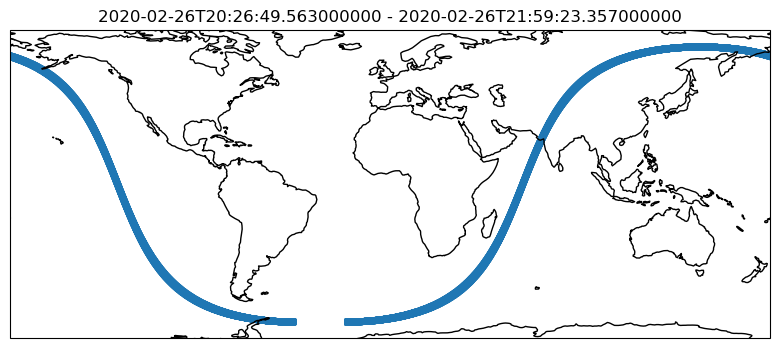

In [142]:
plt.figure(figsize = (15, 4)) 

ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.scatter(src_lons, src_lats, transform=ccrs.PlateCarree(), s = 0.1)
ax.add_feature(cfeature.COASTLINE)
ax.set_title(str(start_time)  + ' - '  + str(end_time))

plt.show()

### Retrieved surface precipitation (from Ku-Band)

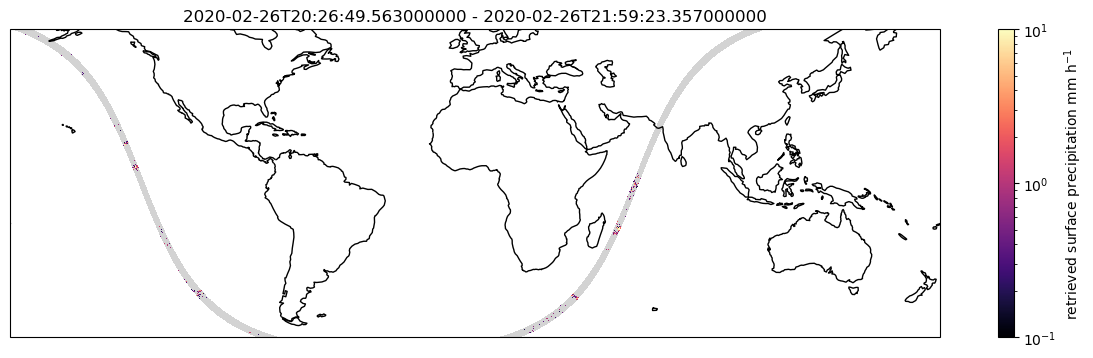

In [143]:
plt.figure(figsize = (15, 4)) 

ax = plt.axes(projection=ccrs.PlateCarree())
cmap = plt.cm.magma
cmap.set_bad('lightgray')
p = ax.pcolormesh(src_lons, src_lats, precip_dpr, transform=ccrs.PlateCarree(), cmap = cmap, norm = LogNorm(1e-1,1e1) )
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-180,180, -60,59])
ax.set_title(str(start_time)  + ' - '  + str(end_time))
plt.colorbar(p, label = 'retrieved surface precipitation mm h$^{-1}$')

plt.show()

### Compare regridded DPR data to matching hourly GPM IMERG snapshot 

In [120]:
# path to regridded file
fname_dpr_regridded = path / '2A.GPM.DPR.V9-20211125.20200226-S202648-E215922.034072.V07A_2020-02-26T21:00:00_regridded.nc'
dpr_regridded = xr.open_dataset(fname_dpr_regridded)
lats = dpr_regridded.lat
lons = dpr_regridded.lon
precip_regridded=  dpr_regridded.precipitation_dpr.squeeze()

# path to global IMERG file for same timestep 
fname_imerg = path / 'olr_pcp_Winter_OBS_2020022612.nc'
imerg = xr.open_dataset(fname_imerg)
imerg_precip = imerg.precipitation.squeeze()

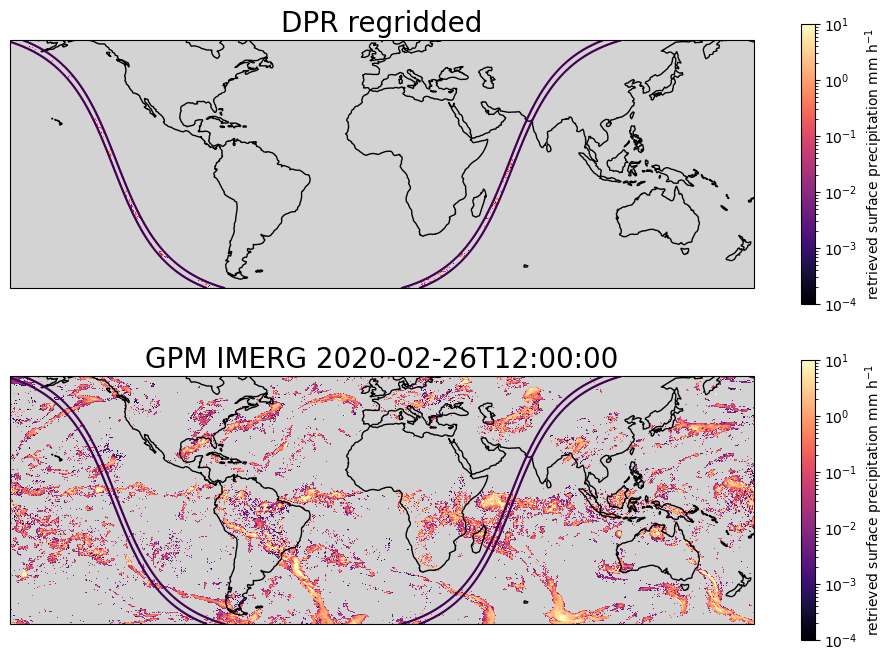

In [172]:
plt.figure(figsize = (12, 8)) 

fs = 20
cmap = plt.cm.magma
cmap.set_bad('lightgray')
cmap.set_under('white')

ax = plt.subplot(2,1,1, projection=ccrs.PlateCarree())
p = ax.pcolormesh(lons, lats, precip_regridded, transform=ccrs.PlateCarree(),  cmap = cmap, norm = LogNorm(1e-4,1e1))
ax.contour(lons, lats, precip_regridded >= 0  )
ax.set_extent([-180,180, -60,60])
ax.add_feature(cfeature.COASTLINE)
ax.set_title('DPR regridded', fontsize = fs)
plt.colorbar(p, label = 'retrieved surface precipitation mm h$^{-1}$')

ax = plt.subplot(2,1,2, projection=ccrs.PlateCarree())
p = ax.pcolormesh(lons, lats, imerg_precip,  transform=ccrs.PlateCarree(),  cmap = cmap, norm = LogNorm(1e-4,1e1))
ax.set_extent([-180,180, -60,60])
ax.add_feature(cfeature.COASTLINE)
ax.contour(lons, lats, precip_regridded >= 0  )

ax.set_title('GPM IMERG ' +  str(imerg.time.data[0])[0:-10], fontsize = fs )
plt.colorbar(p, label = 'retrieved surface precipitation mm h$^{-1}$')

plt.show()